In [35]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from string import ascii_letters
import numpy as np
import folium



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading data

In [37]:
# Load products and sellers data

data_products = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/products.csv")
data_sellers = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/sellers.csv")
data_orders = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/orders.csv")
data_order_items = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/order_items.csv")
data_geolocation = pd.read_csv("/content/drive/MyDrive/Data_Science/SMART buisness test_task/S_Data/geolocation.csv")


Before these step i was checked every table by data.head(1), and after merged them. To made this notebook bit shorter i remove code in 1 block with just merge function

In [38]:
# Let's merge tables. After merge we can observe more complex data

merged_data = data_sellers.merge(data_order_items, how="inner", on="seller_id")
merged_data = merged_data.merge(data_products, how="inner", on="product_id")
merged_data = merged_data.merge(data_orders, how="inner", on="order_id")

# data_geolocation = data_geolocation.rename(columns={"geolocation_zip_code_prefix": "seller_zip_code_prefix"})

# merged_data = merged_data.merge(data_geolocation, how="inner", on="seller_zip_code_prefix")

In [39]:
merged_data["price"].sum()

13591643.7

# Most best and worst sellers

## Best/worst all time sellers

In [40]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   seller_id                      112650 non-null  object 
 1   seller_zip_code_prefix         112650 non-null  int64  
 2   seller_city                    112650 non-null  object 
 3   seller_state                   112650 non-null  object 
 4   order_id                       112650 non-null  object 
 5   order_item_id                  112650 non-null  int64  
 6   product_id                     112650 non-null  object 
 7   shipping_limit_date            112650 non-null  object 
 8   price                          112650 non-null  float64
 9   freight_value                  112650 non-null  float64
 10  product_category_name          111047 non-null  object 
 11  product_name_lenght            111047 non-null  float64
 12  product_description_lenght    

In [41]:
merged_data.shape

(112650, 25)

I can chose interesting me columns from merged data, but for more easier info i'll drop unnecessary columns

In [42]:
merged_data.columns.to_list()

['seller_id',
 'seller_zip_code_prefix',
 'seller_city',
 'seller_state',
 'order_id',
 'order_item_id',
 'product_id',
 'shipping_limit_date',
 'price',
 'freight_value',
 'product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date']

In [43]:
# dropping unnecessary columns

cleaned_data = merged_data.drop(columns=['order_status',
 'shipping_limit_date',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'customer_id',
 'order_status',
 ], axis=1)

In [44]:
cleaned_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,price,freight_value,product_category_name,order_purchase_timestamp
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,106.20,9.56,esporte_lazer,2017-08-21 20:35:44
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,101.70,15.92,esporte_lazer,2017-05-05 16:12:29
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,10.80,2.42,esporte_lazer,2017-08-30 11:47:52
3,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,bc8a5de6abf5b14f98a6135a7fb46731,1,1b37d55343061aa2b18b807945ff9831,118.90,26.68,moveis_escritorio,2017-08-30 11:47:52
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,89.99,45.09,malas_acessorios,2017-11-10 16:54:13


By first we'll define top 10 leaders \ ousiders of all times by all categories in all location

In [45]:
# define best/worst seller

most_value_seller = cleaned_data[["seller_id", "price"]]
most_value_seller = most_value_seller.groupby("seller_id").sum().reset_index()
most_value_seller = most_value_seller.sort_values(by="price",
                                                  ascending=False).reset_index()



In [46]:
top_10_best_valet_sellers = most_value_seller.loc[:9, :].drop(columns="index")

In [47]:
top_10_worst_value_sellers =  most_value_seller.iloc[:-11:-1].drop(columns="index")

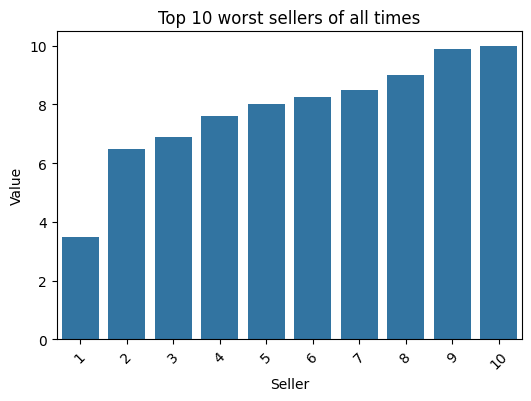

In [48]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=top_10_worst_value_sellers)
plt.xlabel('Seller')
plt.ylabel('Value')
plt.title('Top 10 worst sellers of all times')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

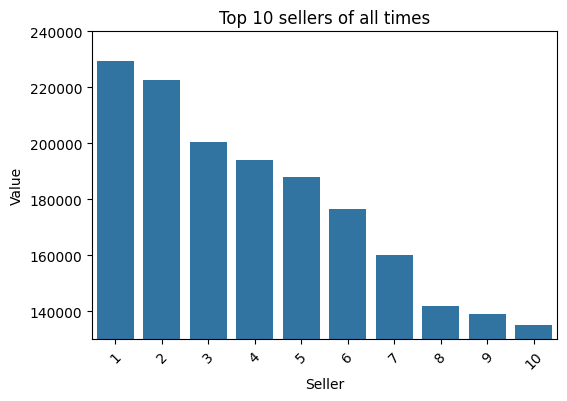

In [49]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=top_10_best_valet_sellers)
plt.ylim(130000,240000)
plt.xlabel('Seller')
plt.ylabel('Value')
plt.title('Top 10 sellers of all times')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

in the worst sellers case we can see that stats looks very small. it is may be 1 timee sells. i will explore set better

In [50]:
most_value_seller.describe()

,index,price
count,3095.000000,3095.000000
mean,1547.000000,4391.484233
std,893.593867,13921.997192
min,0.000000,3.500000
25%,773.500000,208.850000
50%,1547.000000,821.480000
75%,2320.500000,3280.830000
max,3094.000000,229472.630000


Now, i wll filter worst all time sellers by 25 % value price

In [51]:
top_10_worst_value_sellers =  most_value_seller[most_value_seller["price"]>208].iloc[:-11:-1].drop(columns="index")

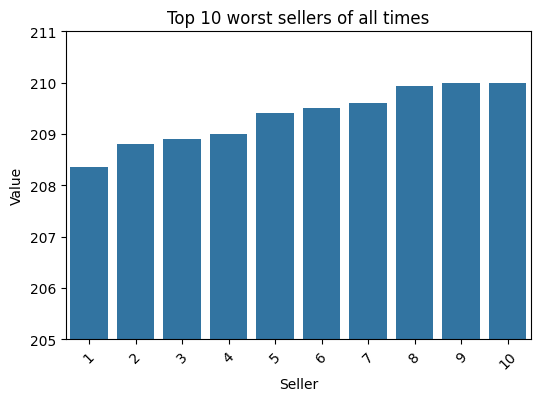

In [52]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=top_10_worst_value_sellers)
plt.ylim(205,211)
plt.xlabel('Seller')
plt.ylabel('Value')
plt.title('Top 10 worst sellers of all times')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

And we'll plot value sells from 1000

In [53]:
top_10_worst_value_sellers =  most_value_seller[most_value_seller["price"]>1000].iloc[:-11:-1].drop(columns="index")

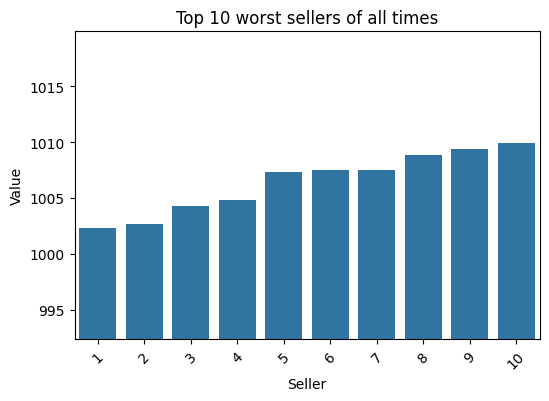

In [54]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=top_10_worst_value_sellers)
plt.ylim(top_10_worst_value_sellers["price"].min()-10,
         top_10_worst_value_sellers["price"].max()+10)
plt.xlabel('Seller')
plt.ylabel('Value')
plt.title('Top 10 worst sellers of all times')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

# Best/worst sellers of the last year

In [55]:
cleaned_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,price,freight_value,product_category_name,order_purchase_timestamp
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,106.20,9.56,esporte_lazer,2017-08-21 20:35:44
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,101.70,15.92,esporte_lazer,2017-05-05 16:12:29
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,10.80,2.42,esporte_lazer,2017-08-30 11:47:52
3,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,bc8a5de6abf5b14f98a6135a7fb46731,1,1b37d55343061aa2b18b807945ff9831,118.90,26.68,moveis_escritorio,2017-08-30 11:47:52
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,89.99,45.09,malas_acessorios,2017-11-10 16:54:13


As we know the "order_purchase_timestamp" column is type = obj
our goal is gather all data sells for last year. to do that we need convert column to datatime and after remove time from data

In [56]:
cleaned_data["order_purchase_timestamp"] = pd.to_datetime(cleaned_data["order_purchase_timestamp"])
cleaned_data["order_purchase_timestamp"] = cleaned_data["order_purchase_timestamp"].dt.floor('D')

Last order day is :

In [57]:
cleaned_data["order_purchase_timestamp"].max()

Timestamp('2018-09-03 00:00:00')

In [58]:
# Let's define data set with last year data

last_year_data = cleaned_data[(cleaned_data['order_purchase_timestamp'] >= '2017-09-03') &
                              (cleaned_data['order_purchase_timestamp'] <= '2018-09-03')]

Check is data time is correct

In [59]:
print("last known date is:", last_year_data["order_purchase_timestamp"].max())
print("first year ago date is:", last_year_data["order_purchase_timestamp"].min())


last known date is: 2018-09-03 00:00:00
first year ago date is: 2017-09-03 00:00:00


Now we can define and plott most 10 best/worst sellers of the last year

In [60]:
#define and loc data

seller_to_price = last_year_data[["seller_id","price"]].groupby("seller_id").sum().reset_index()
seller_to_price = seller_to_price.sort_values(by="price",  ascending=False).reset_index()

best_last_year_sellers = seller_to_price.iloc[:10].reset_index().drop(columns="index")
worst_last_year_sellers = seller_to_price.iloc[:-11:-1].reset_index().drop(columns="index")

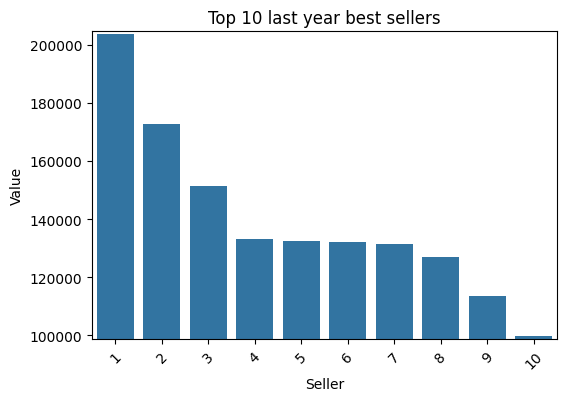

In [61]:
# Build graph with best sellers
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=best_last_year_sellers)
plt.ylim(best_last_year_sellers["price"].min()-1000,
         best_last_year_sellers["price"].max()+1000)
plt.xlabel('Seller')
plt.ylabel('Value')
plt.title('Top 10 last year best sellers')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

Top 3 sellers are are really made good job last year, so let's see worst sellers

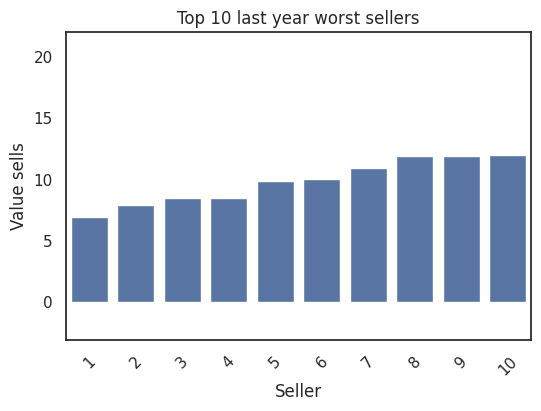

In [131]:
# Build graph with worst sellers
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_id', y='price', data=worst_last_year_sellers)
plt.ylim(worst_last_year_sellers["price"].min()-10,
         worst_last_year_sellers["price"].max()+10)
plt.xlabel('Seller')
plt.ylabel('Value sells')
plt.title('Top 10 last year worst sellers')
plt.xticks(rotation=45, ticks=[0,1,2,3,4,5,6,7,8,9], labels=[1,2,3,4,5,6,7,8,9,10])
plt.show()

and let's observe value sells for the last year

In [63]:
print("\n", "-"*50, "\n                all time sells \n\n",
      most_value_seller.describe(),"\n", "-"*50,)
print("                last year sells \n\n",
      seller_to_price.describe(),"\n", "-"*50)



 -------------------------------------------------- 
                all time sells 

              index          price
count  3095.000000    3095.000000
mean   1547.000000    4391.484233
std     893.593867   13921.997192
min       0.000000       3.500000
25%     773.500000     208.850000
50%    1547.000000     821.480000
75%    2320.500000    3280.830000
max    3094.000000  229472.630000 
 --------------------------------------------------
                last year sells 

              index          price
count  2677.000000    2677.000000
mean   1338.000000    3878.317396
std     772.927659   11593.364139
min       0.000000       6.900000
25%     669.000000     219.800000
50%    1338.000000     834.400000
75%    2007.000000    3104.510000
max    2676.000000  203595.800000 
 --------------------------------------------------



# Top/worst sells by regions

Let's analyse value all time sells by region

In [64]:
cleaned_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,price,freight_value,product_category_name,order_purchase_timestamp
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,106.20,9.56,esporte_lazer,2017-08-21
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,101.70,15.92,esporte_lazer,2017-05-05
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,10.80,2.42,esporte_lazer,2017-08-30
3,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,bc8a5de6abf5b14f98a6135a7fb46731,1,1b37d55343061aa2b18b807945ff9831,118.90,26.68,moveis_escritorio,2017-08-30
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,89.99,45.09,malas_acessorios,2017-11-10


How much states and cities included in our data?

In [65]:
print("states in data: ", cleaned_data["seller_state"].nunique())
print("cities in data: ", cleaned_data["seller_city"].nunique())

states in data:  23
cities in data:  611


Now we can see top 5 best and worst sells in regions

In [66]:
region_sells_data_geolocation = data_geolocation

In [67]:
region_sells_data_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


i was`nt correct merged dataframe, becauese:

In [68]:
region_sells_data_geolocation[
    region_sells_data_geolocation["geolocation_zip_code_prefix"]==1037].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
14,1037,-23.545187,-46.637855,são paulo,SP
31,1037,-23.546705,-46.640336,são paulo,SP
169,1037,-23.543883,-46.638075,são paulo,SP
178,1037,-23.546157,-46.639885,sao paulo,SP


and we can observe, that  city can writting by differrent kinds and for one prefix can be differrent lattitude and longtittude. that's why when i merged this data to main dataset i had problems with extra rows. so now i'll made mean coordinates for each zip code

In [69]:
# Choose just columns that i need, drop duplicate data and gather data with
# lattitude and longtittude by mean

region_sells_data_geolocation = region_sells_data_geolocation.drop_duplicates()
region_sells_data_geolocation = region_sells_data_geolocation[["geolocation_zip_code_prefix",
                                                              "geolocation_lat",
                                                              "geolocation_lng"]]
region_sells_data_geolocation = region_sells_data_geolocation.groupby\
                            ("geolocation_zip_code_prefix").mean().reset_index()

Check for correct data



In [70]:
region_sells_data_geolocation[region_sells_data_geolocation
                                  ["geolocation_zip_code_prefix"]==1037]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
36,1037,-23.545335,-46.638995


In [71]:
location_data = cleaned_data

In [72]:
location_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,price,freight_value,product_category_name,order_purchase_timestamp
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,106.20,9.56,esporte_lazer,2017-08-21
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,101.70,15.92,esporte_lazer,2017-05-05
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,10.80,2.42,esporte_lazer,2017-08-30
3,8c16d1f32a54d92897cc437244442e1b,89023,blumenau,SC,bc8a5de6abf5b14f98a6135a7fb46731,1,1b37d55343061aa2b18b807945ff9831,118.90,26.68,moveis_escritorio,2017-08-30
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,89.99,45.09,malas_acessorios,2017-11-10


In [73]:
merged_location = location_data.merge(region_sells_data_geolocation, how="inner",
                                      right_on="geolocation_zip_code_prefix",
                                      left_on="seller_zip_code_prefix")


Now we can see sellers map

In [74]:
max_x = merged_location["geolocation_lng"].max() * 1.05,
min_x = merged_location["geolocation_lng"].min() * 0.95
max_y = merged_location["geolocation_lat"].max() * 1.05,
min_y = merged_location["geolocation_lat"].min() * 0.95

print(max_x)
print(min_x)

print(max_y)
print(min_y)

(-36.598622028860525,)
-64.42310077687793
(-2.628315486966286,)
-30.471537695534423


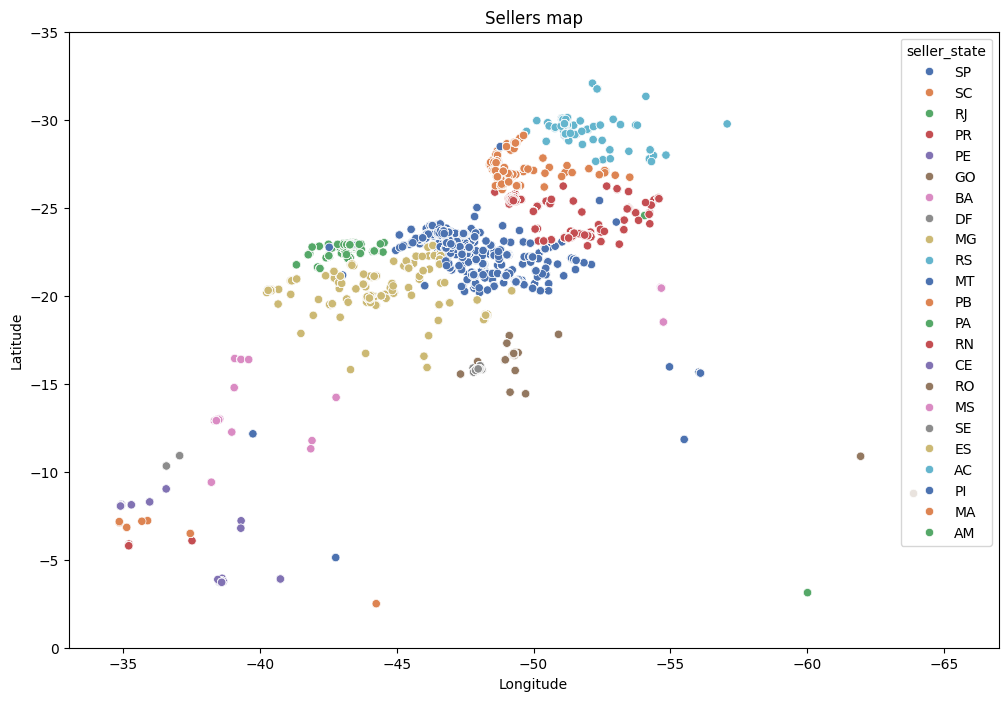

In [75]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="geolocation_lng",y="geolocation_lat",data=merged_location,
                hue="seller_state", palette="deep")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Sellers map")
plt.xlim(-33, -67)
plt.ylim(0, -35)
plt.show()

How it looks on real map:

In [76]:
merged_data[merged_data["price"]==6735.000000]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,...,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
65228,e3b4998c7a498169dc7bce44e6bb6277,3635,sao paulo,SP,0812eb902a67711a1cb742b3cdaa65ae,1,489ae2aa008f021502940f251d4cce7f,2017-02-16 20:37:36,6735.0,194.31,...,60.0,61.0,33.0,c6e2731c5b391845f6800c97401a43a9,delivered,2017-02-12 20:37:36,2017-02-12 20:45:12,2017-02-16 09:23:13,2017-03-03 14:23:18,2017-03-09 00:00:00


In [77]:
merged_data.describe()

,seller_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,112650.000000,112650.000000,112650.000000,112650.000000,111047.000000,111047.000000,111047.000000,112632.000000,112632.000000,112632.000000,112632.000000
mean,24439.170431,1.197834,120.653739,19.990320,48.775978,787.867029,2.209713,2093.672047,30.153669,16.593766,22.996546
std,27596.030909,0.705124,183.633928,15.806405,10.025581,652.135608,1.721438,3751.596884,16.153449,13.443483,11.707268
min,1001.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,6429.000000,1.000000,39.900000,13.080000,42.000000,348.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,13568.000000,1.000000,74.990000,16.260000,52.000000,603.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,27930.000000,1.000000,134.900000,21.150000,57.000000,987.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,99730.000000,21.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


In [78]:
merged_location.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name', 'order_purchase_timestamp',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [79]:
sellers_map = merged_location[["seller_zip_code_prefix","geolocation_lat",
                               "geolocation_lng", "price"]]


sellers_map = sellers_map.groupby("seller_zip_code_prefix").\
        agg({'geolocation_lat':'mean', 'geolocation_lng':'mean', 'price':'sum'})\
        .reset_index()

In [80]:
sellers_map.describe()

,seller_zip_code_prefix,geolocation_lat,geolocation_lng,price
count,2239.000000,2239.000000,2239.000000,2239.000000
mean,31621.108977,-22.957986,-47.176418,6058.801912
std,32642.194530,3.461023,2.951773,20839.188435
min,1001.000000,-32.075303,-67.813790,3.500000
25%,6183.000000,-23.646910,-48.958258,291.445000
50%,15025.000000,-23.502111,-46.711850,1189.280000
75%,58942.500000,-22.410860,-46.503144,4704.125000
max,99730.000000,-2.503158,-34.855831,624592.940000


In [81]:
sellers_map["price"].describe()

count      2239.000000
mean       6058.801912
std       20839.188435
min           3.500000
25%         291.445000
50%        1189.280000
75%        4704.125000
max      624592.940000
Name: price, dtype: float64

Conclusions:



Wide range of values: The data shows a significant difference in sales between different transactions. The highest sale is almost 180,000 times larger than the lowest. This may indicate that there is a variety of types of products or services being sold, or that there are different sales channels with different average transaction values.

Slight skewness to the right: The distribution of the data is slightly skewed to the right, meaning that more transactions had close to average sales and a minority of transactions had significantly higher sales. This could be due to having a few very expensive products or services in your product mix.

High potential for revenue growth: There is significant potential to increase revenues by focusing on transactions with high sales. This can be achieved by

marketing these products or services more effectively, offering incentives to purchase them, or

improving the sales process for these transactions.

Recommendations:



Conduct a more detailed analysis: It is recommended that you conduct a more detailed analysis of the data to determine the factors that influence sales volume. This may include analyzing the type of product, sales channel, geographic location of the customer, and other related factors.

Develop strategies to increase revenue: Based on your analysis, develop targeted strategies to increase revenue from high-selling transactions.

Track and evaluate results: It is important to track the results of the implemented strategies and make adjustments as needed.

Exporing sellers geographic location

Now we can see map with sellers by value of sells to zip code

In [82]:

# Initiate map
m = folium.Map(location=[sellers_map['geolocation_lat'].mean(),
                         sellers_map['geolocation_lng'].mean()], zoom_start=10)

# Loop adding markers on the map
for index, row in sellers_map.iterrows():
    # adding marker that depending on price
    folium.CircleMarker(location=[row['geolocation_lat'], row['geolocation_lng']],
                        radius=row['price']/5000,
                        color='blue', fill=True, fill_color='blue').add_to(m)

# print map
m

From this map we can conclude that there is an opportunity to develop sales south to Porto Alegre, as there are enough sellers there to generate a profit of about 10% to 25% of the maximum revenue. Near the city of Salvador, where there is a demand for goods, it is also possible to expand the structure as there are quite large sales there. The cities of Jaboatao dos Guararapes and Sao Luis give small profits despite the fact that there is only one seller there. Perhaps these areas need to attract more outlets. Fortaleza has many vendors, but low sales, which indicates poor marketing. the rest of the region is a patchwork of outlets with low sales where attention should be paid to population density and welfare.

It is also important to consider the size of the market and the level of competition in different regions.

This data shows that there is significant potential to improve the performance of sellers with poor geolocation performance.

The business value of using this data:



This data can be used to identify and focus on salespeople who need improvement.

It can be used to develop targeted sales strategies for different salesperson segments.

It can be used to track progress and measure the effectiveness of sales strategies.

And how about top 5 regions with most value of sells?

In [83]:
merged_location.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name', 'order_purchase_timestamp',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [84]:
# data grouped by state:

sells_by_regions = merged_location[['price','seller_state']].groupby("seller_state").sum().reset_index()
# Sort it by price
sells_by_regions = sells_by_regions.sort_values("price", ascending=False).reset_index()
sells_by_regions=sells_by_regions.drop(columns="index")
sells_by_regions

,seller_state,price
0,SP,8739354.99
1,PR,1261096.21
2,MG,1008407.54
3,RJ,843984.22
4,SC,632426.07
5,RS,378465.54
6,BA,285561.56
7,PE,91493.85
8,DF,89846.68
9,GO,66399.21


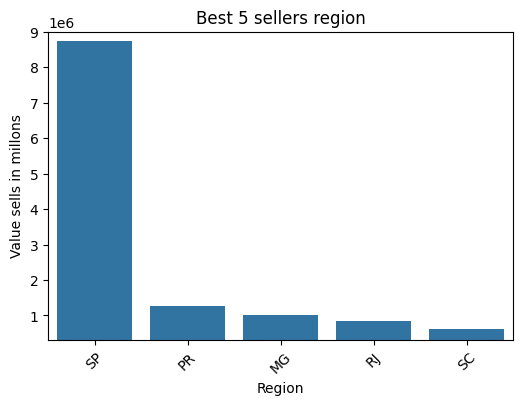

In [85]:
# Best 5 sellers region

best5_sells_by_regions = sells_by_regions.iloc[:5,:]


# Build graph with Best 5 sellers region
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_state', y='price', data=best5_sells_by_regions)
plt.ylim(best5_sells_by_regions["price"].min() * 0.5,
         best5_sells_by_regions["price"].max() * 1.03)
plt.xlabel('Region')
plt.ylabel('Value sells in millons')
plt.title('Best 5 sellers region')
plt.xticks(rotation=45,)
plt.show()

Now we see, that San Paulo made sells near 9 millions , when other 4 near 1 million.  

**A small number of regions generate most of the sales**

Next plot is top 5 worst sells regions

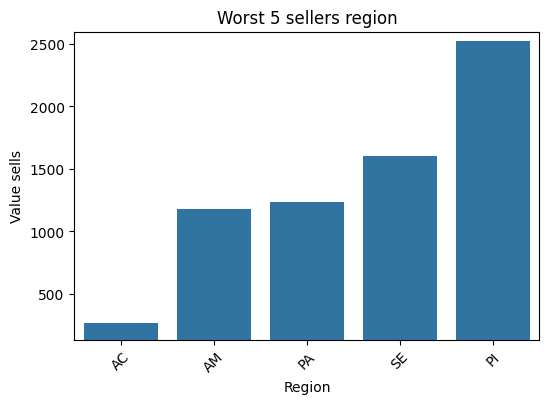

In [86]:
# Worst 5 sellers region

worst5_sells_by_regions = sells_by_regions.iloc[:-6:-1]


# Build graph with Best 5 sellers region
plt.figure(figsize=(6, 4))
sns.barplot(x='seller_state', y='price', data=worst5_sells_by_regions)
plt.ylim(worst5_sells_by_regions["price"].min() * 0.5,
         worst5_sells_by_regions["price"].max() * 1.03)
plt.xlabel('Region')
plt.ylabel('Value sells')
plt.title('Worst 5 sellers region')
plt.xticks(rotation=45,)
plt.show()

it is necessary to study the situation in detail for the further development of these regions, because sales volumes are not enough to draw conclusions

# ***Analysis of cities***

Now we observe data by cities

In [87]:
merged_location.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name', 'order_purchase_timestamp',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

To avoid mistakes in cities name i'll group by zip code

In [88]:
cities_check = merged_location.groupby(["seller_zip_code_prefix","seller_city"]).\
        agg({'geolocation_lat':'mean', 'geolocation_lng':'mean', 'price':'sum'})\
        .reset_index()


# cities_check = merged_location.groupby(['seller_zip_code_prefix', 'seller_city',
#                                       'seller_state'])['price','geolocation_lat',
#                                         'geolocation_lng'].sum().reset_index()

That's no surprise that Sao paulo leader, because it's population more than 12 million

As i know from Wikipedia zip codes Sao Paulo Starts from 1000 and ends 5999
How much zip indexes by sellers in Sao paulo:



In [89]:
cities_check[(cities_check["seller_zip_code_prefix"] >= 1000) &
                                (cities_check["seller_zip_code_prefix"] < 6000)]

,seller_zip_code_prefix,seller_city,geolocation_lat,geolocation_lng,price
0,1001,sao paulo,-23.550227,-46.634039,826.99
1,1021,sao paulo,-23.542835,-46.632099,7091.01
2,1022,sao paulo,-23.544781,-46.632063,487.50
3,1023,sao paulo,-23.542359,-46.631364,157.65
4,1026,sao paulo,-23.539639,-46.632154,26216.99
...,...,...,...,...,...
541,5782,sao paulo,-23.650985,-46.766495,266.70
542,5786,sao paulo,-23.634927,-46.772219,579.50
543,5849,sao paulo,-23.652867,-46.756262,124493.06
544,5856,sao paulo,-23.651552,-46.784246,68.00


In [90]:
# Merge all zip Sao Paulo in 1

cities_check["seller_city"] = cities_check.apply(lambda x: "Sao Paulo" if
                                          x["seller_zip_code_prefix"]>=1000 and
                                           x["seller_zip_code_prefix"]<6000 else
                                            x["seller_zip_code_prefix"], axis=1)

In [91]:
# Now remove zip code from data and group by city
cities_check = cities_check.drop(columns="seller_zip_code_prefix", axis=1)
cities_check = merged_location.groupby(["seller_city"]).\
        agg({'geolocation_lat':'mean', 'geolocation_lng':'mean', 'price':'sum'})\
        .reset_index()

In [92]:
cities_check

,seller_city,geolocation_lat,geolocation_lng,price
0,04482255,-23.013945,-43.463020,399.90
1,abadia de goias,-16.767161,-49.438178,142.47
2,afonso claudio,-20.076743,-41.123686,293.99
3,aguas claras df,-15.832887,-48.029378,35.00
4,alambari,-23.561571,-47.885101,138.60
...,...,...,...,...
606,volta redonda,-22.497535,-44.127404,12954.79
607,votorantim,-23.542137,-47.456499,20056.34
608,votuporanga,-20.417168,-49.984100,21107.47
609,xanxere,-26.876412,-52.404587,2297.05


Now, see on map

In [93]:
# Initiate map
m = folium.Map(location=[cities_check['geolocation_lat'].mean(), cities_check['geolocation_lng'].mean()], zoom_start=10)

# Loop adding markers
for index, row in cities_check.iterrows():
    # Adding marker size depending on price
    folium.CircleMarker(location=[row['geolocation_lat'], row['geolocation_lng']], radius=row['price']/5000,
                        color='blue', fill=True, fill_color='blue').add_to(m)

# Print map
m

This map provides us with information about sales in cities. We can conclude that despite the high competition in some cities, profits are much higher than in others. You need to pay attention to sellers in these cities where citywide sales are high. If the seller's sales in such cities are low, it may be due to competition or incorrectly selected products or marketing. In the following slides, we will take a closer look at which products are most popular and which sellers sell them...



More information can give location by geodata, so i'll change Sao Paulo feautures:

In [94]:
merged_location.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'price', 'freight_value',
       'product_category_name', 'order_purchase_timestamp',
       'geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [95]:
sao_paulo_data = merged_location[["seller_zip_code_prefix", "seller_city",
                                  "price", 'geolocation_lat', 'geolocation_lng']]
sao_paulo_data = sao_paulo_data[(sao_paulo_data["seller_zip_code_prefix"] >= 1000) &
                                (sao_paulo_data["seller_zip_code_prefix"] < 6000)]

In [96]:
sao_paulo_data.head()

,seller_zip_code_prefix,seller_city,price,geolocation_lat,geolocation_lng
176,4195,sao paulo,79.99,-23.657118,-46.612730
1158,3431,sao paulo,56.90,-23.551180,-46.537314
1159,3431,sao paulo,64.90,-23.551180,-46.537314
1160,3431,sao paulo,64.90,-23.551180,-46.537314
1161,3431,sao paulo,121.90,-23.551180,-46.537314


In [97]:
sao_paulo_data = sao_paulo_data.groupby("seller_zip_code_prefix").\
        agg({'geolocation_lat':'mean', 'geolocation_lng':'mean', 'price':'sum'})\
        .reset_index()

How it looks in real map:

On this map we can see a detailed picture of sales in Sao Paulo.

In [98]:
# Initiate map
m = folium.Map(location=[sao_paulo_data['geolocation_lat'].mean(), sao_paulo_data['geolocation_lng'].mean()], zoom_start=10)

# Loop adding markers
for index, row in sao_paulo_data.iterrows():
    # Adding marker size depending on price
    folium.CircleMarker(location=[row['geolocation_lat'], row['geolocation_lng']], radius=row['price']/5000,
                        color='blue', fill=True, fill_color='blue').add_to(m)

# Print map
m


In [99]:
sao_paulo_data.describe()

,seller_zip_code_prefix,geolocation_lat,geolocation_lng,price
count,544.000000,544.000000,544.000000,544.000000
mean,3524.465074,-23.564124,-46.628010,4776.323346
std,1275.896370,0.062061,0.074469,13657.359017
min,1001.000000,-23.781059,-46.791328,3.500000
25%,2722.750000,-23.603477,-46.685017,214.325000
50%,3550.500000,-23.553873,-46.633355,973.965000
75%,4484.000000,-23.525435,-46.576475,3909.185000
max,5879.000000,-23.413225,-46.469964,141745.530000


In Sao Paulo itself, we see that there are only 4 large players and 8 medium-sized ones. according to the data, 20% of sellers generate the main profit. in this city, there is a lot of room for development, as there is room for growth for other players.

# Sales analysis according to turnover

Let's see what products are sold by all sellers

In [100]:
merged_data.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [101]:
# define features to observe categories
categories_data = merged_data[["seller_zip_code_prefix", 'seller_state',
                              'seller_city', 'price','order_item_id',
                               'product_category_name']]

Check how much rows categories absent

In [102]:
categories_data["product_category_name"].isna().sum()

1603

Since this is less than 1%, I will simply delete the missing data

In [103]:
categories_data.dropna(inplace=True)
#and check other data
categories_data.isna().sum()

<ipython-input-103-e8f0bb58bc00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories_data.dropna(inplace=True)


seller_zip_code_prefix    0
seller_state              0
seller_city               0
price                     0
order_item_id             0
product_category_name     0
dtype: int64

Let's see which categories are the most profitable

In [104]:
categories_to_price = categories_data[["product_category_name", "price"]]

In [105]:
# group by category and sort by price
categories_to_price = categories_to_price.groupby("product_category_name")\
                                                      .sum().reset_index()
categories_to_price = categories_to_price.sort_values("price", ascending=False)\
                        .reset_index().drop(columns="index")


Top 10 most profitable categories:

In [106]:
best_profitable_cat = categories_to_price.iloc[:10]
best_profitable_cat

,product_category_name,price
0,beleza_saude,1258681.34
1,relogios_presentes,1205005.68
2,cama_mesa_banho,1036988.68
3,esporte_lazer,988048.97
4,informatica_acessorios,911954.32
5,moveis_decoracao,729762.49
6,cool_stuff,635290.85
7,utilidades_domesticas,632248.66
8,automotivo,592720.11
9,ferramentas_jardim,485256.46


In [107]:
best_profitable_cat["price"].describe()

count    1.000000e+01
mean     8.475958e+05
std      2.704021e+05
min      4.852565e+05
25%      6.330092e+05
50%      8.208584e+05
75%      1.024754e+06
max      1.258681e+06
Name: price, dtype: float64

In [108]:
best_profitable_cat["product_category_name"].unique()

array(['beleza_saude', 'relogios_presentes', 'cama_mesa_banho',
       'esporte_lazer', 'informatica_acessorios', 'moveis_decoracao',
       'cool_stuff', 'utilidades_domesticas', 'automotivo',
       'ferramentas_jardim'], dtype=object)

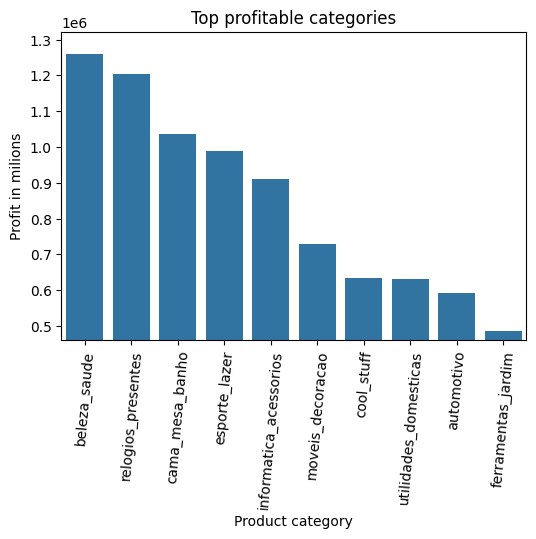

In [109]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='product_category_name', y='price', data=best_profitable_cat)
plt.ylim(best_profitable_cat["price"].min()*0.95,
         best_profitable_cat["price"].max()*1.05)
plt.xlabel('Product category')
plt.ylabel('Profit in milions')
plt.title('Top profitable categories')
plt.xticks(rotation=85, ticks=[0,1,2,3,4,5,6,7,8,9], labels=['beleza_saude',
                                      'relogios_presentes', 'cama_mesa_banho',
                'esporte_lazer', 'informatica_acessorios', 'moveis_decoracao',
                'cool_stuff', 'utilidades_domesticas', 'automotivo',
                'ferramentas_jardim'])
plt.show()

Based on this data, it is recommended to focus on the most profitable product categories, such as Health and Beauty, Watches and Gifts, and Beds, Furniture, and Bathrooms.

It is also recommended to develop targeted marketing strategies for each product category.

Now let's look at the best-selling categories

In [110]:
merged_data.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [111]:
# group by category and sort by quantyty
categories_to_qty = merged_data[["product_category_name","order_item_id"]]
categories_to_qty = categories_to_qty.groupby("product_category_name")\
                                                      .sum().reset_index()
categories_to_qty = categories_to_qty.sort_values("order_item_id", ascending=False)\
                        .reset_index().drop(columns="index")


In [112]:
best_qty_cat = categories_to_qty.iloc[:10]

In [113]:
best_qty_cat_list = best_qty_cat["product_category_name"].unique().tolist()

Top 10 value sells categories

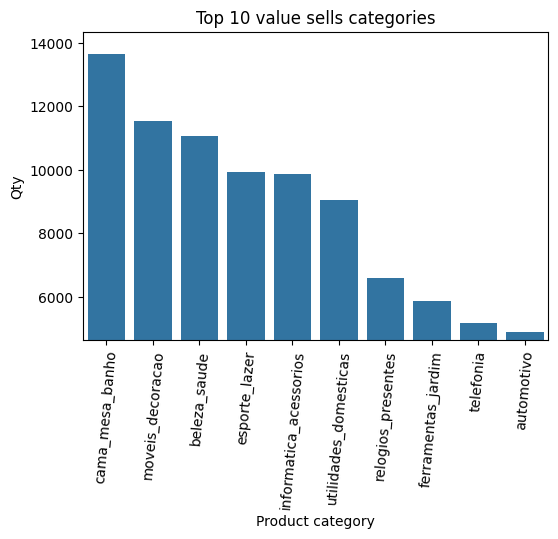

In [114]:
# Build graph
plt.figure(figsize=(6, 4))
sns.barplot(x='product_category_name', y='order_item_id', data=best_qty_cat)
plt.ylim(best_qty_cat["order_item_id"].min()*0.95,
         best_qty_cat["order_item_id"].max()*1.05)
plt.xlabel('Product category')
plt.ylabel('Qty')
plt.title('Top 10 value sells categories')
plt.xticks(rotation=85, ticks=[0,1,2,3,4,5,6,7,8,9], labels=best_qty_cat_list)
plt.show()

Let's compare top 10 profitable categories and top sells categories

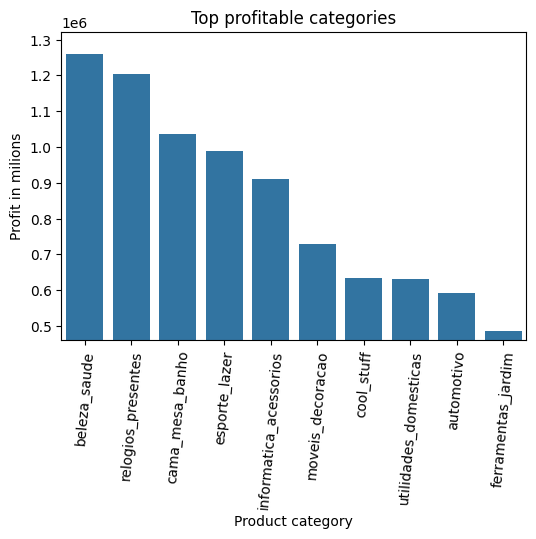
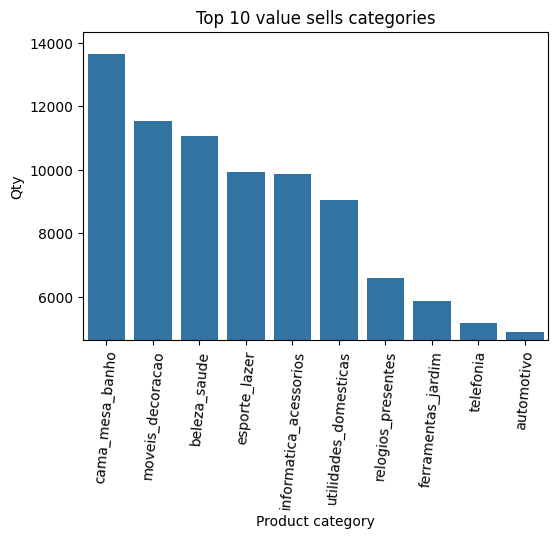

The Health and Beauty and Watches and Gifts categories are the most profitable for the company, while the Electronics and Clothing and Footwear categories generate the largest sales.

Focus on marketing efforts in the Health and Beauty and Watches and Gifts categories to increase profits.

Consider expanding product offerings in the Electronics and Apparel & Footwear categories to increase sales.

Analyze profit margins across all categories to identify opportunities for improvement.

Develop strategies to optimize pricing and marketing in each category.

Therefore, with this data, we can help sellers to develop further

**Аналіз найбільш продаваємих категорій по регіонам**



In [115]:
merged_data.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [116]:
category_to_region = merged_data[["seller_state", "order_item_id", "product_category_name"]]

In [117]:
category_to_region = category_to_region.groupby(["product_category_name", "seller_state"]).sum().reset_index()

In [118]:
category_to_region = category_to_region.sort_values("order_item_id", ascending=False).reset_index().drop(columns="index")

In [119]:
category_to_region

,product_category_name,seller_state,order_item_id
0,cama_mesa_banho,SP,12061
1,moveis_decoracao,SP,9008
2,beleza_saude,SP,7447
3,utilidades_domesticas,SP,6594
4,esporte_lazer,SP,6247
...,...,...,...
498,moveis_quarto,RJ,1
499,relogios_presentes,DF,1
500,moveis_quarto,RS,1
501,climatizacao,MS,1


In [120]:
category_to_region.describe()

,order_item_id
count,503.000000
mean,264.528827
std,1004.926630
min,1.000000
25%,4.000000
50%,22.000000
75%,110.000000
max,12061.000000


50% of categories have an indicator of 22 sales, which is very low. let's evaluate those categories that are in the top 50%.



In [121]:
category_to_region = category_to_region[category_to_region["order_item_id"]>22]

In [122]:
category_to_region.head()

,product_category_name,seller_state,order_item_id
0,cama_mesa_banho,SP,12061
1,moveis_decoracao,SP,9008
2,beleza_saude,SP,7447
3,utilidades_domesticas,SP,6594
4,esporte_lazer,SP,6247


In [123]:
top_selling_per_state = category_to_region.groupby("seller_state").apply(lambda x: x.nlargest(5, "order_item_id")).reset_index(drop=True)


Scroll and explore best categories sells in every state

In [124]:
import plotly.graph_objs as go

# Create a list of figures for each state
figures = []

for state in top_selling_per_state["seller_state"].unique():
    # Filter data by state
    data_state = top_selling_per_state[top_selling_per_state["seller_state"] == state]

    # Create a plot
    fig = go.Figure()
    fig.add_trace(go.Bar(x=data_state["product_category_name"],
                         y=data_state["order_item_id"],
                         marker=dict(color="blue"),
                         hoverinfo="y"))

    # Set layout and styling
    fig.update_layout(title=f"Top 5 selling categories in {state}",
                      xaxis_title="Product Category",
                      yaxis_title="Quantity",
                      bargap=0.1,
                      plot_bgcolor="rgba(0,0,0,0)")

    # Add the plot to the list of figures
    figures.append(fig)

# Display the list of figures
for fig in figures:
    fig.show()


# ***Analysis of the dependence of product weight on turnover and price***

 To find out the relationship between these categories, I will use a correlation graph

In [125]:
merged_data.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'order_id', 'order_item_id', 'product_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [126]:
check_dependence = merged_data[["order_item_id", 'freight_value', 'price']]

In [127]:
check_dependence.head()

,order_item_id,freight_value,price
0,1,9.56,106.20
1,1,15.92,101.70
2,2,2.42,10.80
3,1,26.68,118.90
4,1,45.09,89.99


<Axes: >

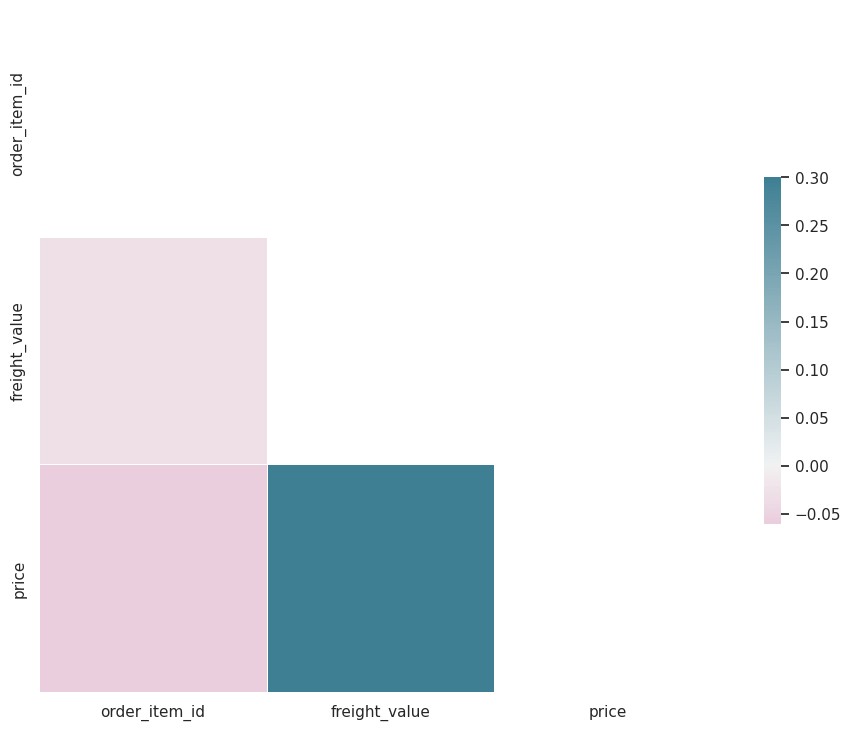

In [128]:
# Let's see correlation by plot

sns.set_theme(style="white")



# Compute the correlation matrix
corr = check_dependence.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(340, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From this figure we can see that the weight was highly dependent on the price, but not on the number of orders

Let's see by experiment by linear regression:

In [129]:
check_dependence.columns

Index(['order_item_id', 'freight_value', 'price'], dtype='object')

Ordinary Least Squares regression OLS) is a common technique for estimating coefficients of linear regression equations which describe the relationship between one or more independent quantitative variables and a dependent variable (simple or multiple linear regression)

In [130]:
import statsmodels.formula.api as smf
model = smf.ols('freight_value ~ order_item_id + price ', data=check_dependence).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          freight_value   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 08 May 2024   Prob (F-statistic):               0.00
Time:                        13:12:13   Log-Likelihood:            -4.6020e+05
No. Observations:              112650   AIC:                         9.204e+05
Df Residuals:                  112647   BIC:                         9.204e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        15.8076      0.091    174.520

The coefficient of determination (R^2) is 0.172, which is quite low. This means that the model does not explain much of the variation in the dependent variable (freight_value).

So, after studying the correlation map and ols regression, I can say for sure that the weight of the product affects only the price, but does not affect the number of sales

# Conclusions

1. Introduction

This report provides sales analysis based on the graphs and data provided.

The purpose of this report is to help you better understand which categories of

products that generate the most profit, identify opportunities to increase sales

to increase sales and develop effective marketing strategies.



2. Graph analysis



Comparison of "Top profitable categories" and "Top 10 value sells categories"

The Health & Beauty and Watches & Gifts categories have the highest profits, but not necessarily the highest sales.

The Electronics and Clothing & Footwear categories have the highest total sales value, but not necessarily the highest profit margin.

Conclusions:

Not all categories that generate high sales are the most profitable.
After analyzing the best-selling products, we received an analysis of needs by region, which can help to increase productivity in the future

It is important to consider both sales and profit margins when evaluating category performance.

3. Correlation analysis.



Based on the image of the correlation matrix provided, the existence of relationships between various variables that affect sales was identified.

To draw more detailed conclusions, it is necessary to analyze the actual values of the variables and the reasons for these correlations.

4. Recommendations



Marketing:

Focus efforts on marketing the Health and Beauty and Watches and Gifts categories to increase profits.

Consider expanding the range of products in the Electronics and Clothing and Footwear categories to increase sales.

Analyze profit margins across all categories to identify opportunities for pricing and marketing optimization.

Develop pricing and marketing strategies to increase sales.